In [9]:
import django
import sys, os
import platform
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import timedelta
import numpy as np

if platform.node() == "srv-mcc-apsis":
    #sys.path.append("/home/galm/software/django/tmv/BasicBrowser/")
    sys.path.append('/home/leey/tmv/BasicBrowser/')
else:
    # local paths
    sys.path.append('/home/leey/Documents/Data/tmv/BasicBrowser/')
os.environ.setdefault("DJANGO_SETTINGS_MODULE", "BasicBrowser.settings")
django.setup()

#import from appended path
import scoping.models as sm
import twitter.models as tm
import parliament.models as pm

from django.db.models import Sum, Count, Q
from django.db.models.fields import DateField
from django.db.models.functions import Cast
import textwrap as tw
import datetime
import random

import igraph
#import mpld3

from adjustText import adjust_text

In [3]:
p = sm.Project.objects.get(pk=196)

In [4]:
end_date = datetime.datetime.strptime('2019-09-30-+0000', '%Y-%m-%d-%z')

In [12]:
# Get tweets related to the project
searches = tm.TwitterSearch.objects.filter(project_list=p)

In [13]:
ttweets = set(tm.Status.objects.filter(
    searches__in=searches,
    text__isnull=False,
    retweeted_status__isnull=True,
    created_at__lte=end_date
).values_list('id',flat=True))

In [14]:
print(len(ttweets))

233059


---

## Language from BaseModel

In [15]:
random.seed(123)
test_texts = tm.Status.objects.filter(
    id__in=random.sample(ttweets, 1000)
).values_list('text', 'lang')

In [16]:
df_test = pd.DataFrame(list(test_texts), columns=['text', 'lang'])

In [18]:
is_de = df_test["lang"]=="de"
df_de = df_test[is_de]

In [19]:
df_de.head()

,text,lang
0,Atom- und Kohleausstieg gleichzeitig geht nich...,de
1,@ntvde Ich hätte zuerst Kohleausstieg bzw. Aus...,de
2,So eindeutig/konsequent Schwarz/Gelb Energiewe...,de
3,"Schade. Der ""Kohleausstieg bis 2030"" hat nur f...",de
4,SRU Vorsitzender empfiehlt Kohleausstieg\nZEIT...,de


In [10]:
#df_test.to_csv("df_test.csv")

In [13]:
#df_de.to_csv('df_de.csv')

---

## Filter for relevant keywords

filter tweets in 'Kohle' set using relevant hashtags, then add tweets from other TS objects to joint dataset?  

In [7]:
# Q lookup must precede any keyword argument
ktf = tm.Status.objects.filter(
    Q(text__icontains = '#hambacherforst') |
    Q(text__icontains = '#fridaysforfuture') |
    Q(text__icontains = '#endegelaende') |
    Q(text__icontains = '#hambacherwald') |
    Q(text__icontains = '#lausitz') |
    Q(text__icontains = '#klimaschutz') |
    Q(text__icontains = '#klimawandel') |
    Q(text__icontains = '#klimakrise') |
    Q(text__icontains = '#klima')
)
#.filter(text__icontains="Kohle")

ktf.count()

1132554

In [8]:
ktff = ktf.filter(
    text__icontains="Kohle"
).filter(
    created_at__lte=end_date
)
ktff.count()

77733

In [20]:
query2 = tm.Status.objects.filter(
    searches__in=searches,
    text__isnull=False,
    retweeted_status__isnull=True,
    created_at__lte=end_date
)

### combining tweets

In [21]:
qcomb = ktff | query2

In [22]:
qcomb.count()

350804

In [25]:
qcomb_ids = set(qcomb.values_list('id',flat=True))

---

## Sentiment Analysis

In [30]:
import spacy
from spacy_sentiws import spaCySentiWS

nlp = spacy.load('de')
sentiws = spaCySentiWS(sentiws_path='../SentiWS')
nlp.add_pipe(sentiws)

In [61]:
def get_senti_score(tweet):
    """gets the score of a tweet from SentiWS"""
    scores = []
    for token in tweet:
        score = token._.sentiws
        if score is not None:
            scores.append(score)
    
    if sum(scores) != 0:
        return sum(scores)/len(tweet)
    else:
        return 0

### testing on small set

In [47]:
df_de.iloc[2]['text']

'So eindeutig/konsequent Schwarz/Gelb Energiewende blockiert, so unentschlossen ist SPD in Sachen Kohleausstieg und Offshore-Wahnsinn. Schade'

In [51]:
len(df_de.iloc[2]['text'].split())

15

In [53]:
doc = nlp(df_de.iloc[2]['text'])
for token in doc: 
    print('{}, {}, {}'.format(token.text, token._.sentiws, token.pos_))

So, None, ADV
eindeutig/konsequent, None, VERB
Schwarz/Gelb, None, PROPN
Energiewende, None, NOUN
blockiert, -0.3459, VERB
,, None, PUNCT
so, None, ADV
unentschlossen, None, ADJ
ist, None, AUX
SPD, None, PROPN
in, None, ADP
Sachen, None, NOUN
Kohleausstieg, None, NOUN
und, None, CONJ
Offshore-Wahnsinn, None, NOUN
., None, PUNCT
Schade, -0.0048, ADJ


In [62]:
get_senti_score(doc)

-0.020629411764705882

In [63]:
tweet_scores = []
for i in df_de.index:
    entry = df_de.loc[i]
    doc = nlp(entry['text'])
    tweet_score = get_senti_score(doc)
    tweet_scores.append(tweet_score)

In [64]:
df_de['score'] = tweet_scores

/home/leey/tmv/BasicBrowser/venv/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [28]:
#df_de.to_csv("df_de_scores2.csv")

In [65]:
most_neg = df_de.sort_values(by=['score'])[0:5]
for i in most_neg.index:
    print(most_neg.loc[i]['text'])

"Die Garantie fehlt" https://t.co/e0J68h2Aez #hambibleibt
#Kohleausstieg - Zukunft des HambacherForst weiter unklar https://t.co/oHnJ0j8sTi
Uneinigkeit beim G20-Gipfel https://t.co/6UtjS3QOch #hambibleibt
@bmel @JuliaKloeckner Elende Heuchler. #Hambibleibt
16:36 Eine Person wird aus der Traverse geholt. Geräumte Person vom Tripod in schlechter körperlicher Verfassung, Schuld ist gerissener Geduldsfaden der Polizei – Räumungen werden gewaltätiger.
#hambibleibt #HambacherForst


In [67]:
most_pos = df_de.sort_values(by=['score'], ascending=False)[0:5]
for i in most_pos.index:
    print(most_pos.loc[i]['text'])

Tolle Neuigkeiten! #hambibleibt https://t.co/cysxrRVBuP
Guten Morgen allerseits. Wünsche allen auf dem Weg zum #hambacherforst eine sichere und angenehme Anfahrt. Viel Erfolg heute. #hambibleibt
Ein wohl verdienter Feierabend! Tolle Menschen :)

 #HambacherForst #HambiBleibt #AktionUnterholz #BuirerFuerBuir https://t.co/eek3hMHJmh
Spannender Augenzeugenbericht zum Tagebau #hambach dem #Hambacherforst und dessen entwicklung #Hambibleibt https://t.co/jSylMYyFvL
Was für eine tolle Idee. Kommt schon! #hambibleibt https://t.co/X6o0gNmP76


---

### Actual

In [68]:
texts = tm.Status.objects.filter(
    id__in=qcomb_ids
).values_list('id','created_at','text', 'lang')

In [69]:
df_texts = pd.DataFrame(list(texts), columns=['id','created_at','text', 'lang'])

In [70]:
is_de = df_texts["lang"]=="de"
texts_de = df_texts[is_de]

In [71]:
texts_scores = []
for i in texts_de.index:
    entry = texts_de.loc[i]
    doc = nlp(entry['text'])
    tweet_score = get_senti_score(doc)
    texts_scores.append(tweet_score)

In [72]:
texts_de['score'] = texts_scores

/home/leey/tmv/BasicBrowser/venv/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [73]:
texts_de.to_csv('texts_de_20200218.csv')

---

### Results

In [4]:
#texts_de = pd.read_csv('texts_de.csv', index_col=[0])

In [74]:
# Style
sns.set_style('whitegrid')

In [5]:
# convert to datetime object
texts_de['created_at'] =  pd.to_datetime(texts_de['created_at'])

In [75]:
texts_de.head()

,id,created_at,text,lang,score
1,5944270614,2009-11-22 11:55:21+00:00,"Die USA bremsen #Klimaabkommen, weil sie noch ...",de,0.000174
2,5978704331,2009-11-23 15:17:24+00:00,#Schottland: #Waldbesetzung gegen #Kohle-#Tage...,de,-0.020047
3,6089959841,2009-11-26 19:18:40+00:00,#Klimaschutz: Eine Maßnahme hilft wirklich: Ko...,de,0.008653
4,6230764335,2009-12-01 09:41:27+00:00,ak2 diskutiert Mindestwirkungsgrad bei Kohle- ...,de,0.000000
5,6265364638,2009-12-02 10:05:53+00:00,#Klimawandel: im Moment haben offenbar die Pro...,de,0.000000


In [76]:
len(texts_de)

240927

In [77]:
average_score = sum(texts_de['score'])/len(texts_de['score'])
average_score

-0.0012697723598929813

In [216]:
texts_de_daily_count = texts_de.groupby(pd.Grouper(key='created_at',freq='D'))['id'].count()

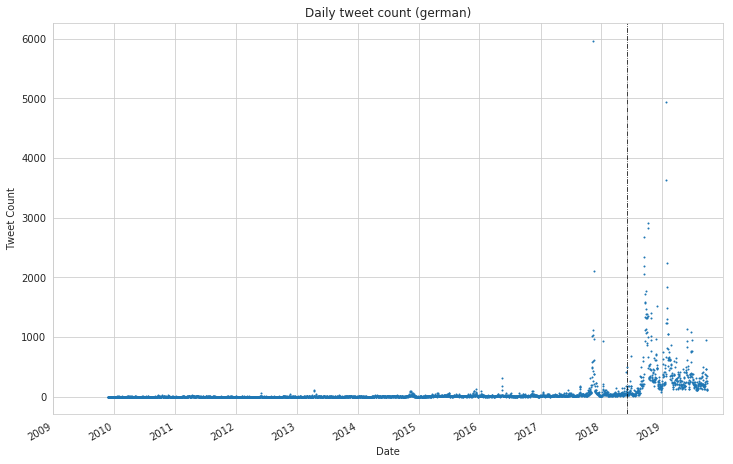

In [272]:
# tweet freq over time
fig, ax = plt.subplots(figsize=(12,8))
sns.scatterplot(texts_de_daily_count.index, texts_de_daily_count, marker='.', s=6, edgecolor=None)
ax.set(xlim=(datetime.datetime.strptime('2009-01-01', '%Y-%m-%d'), datetime.datetime.strptime('2019-12-31', '%Y-%m-%d')),
       #ylim=(0,1000),
       xlabel="Date",
       ylabel="Tweet Count", 
       title="Daily tweet count (german)")
ax.axvline(x=(datetime.datetime.strptime('2018-06-06', '%Y-%m-%d')), ls ='-.',lw='0.75', c = 'k')
fig.autofmt_xdate()
plt.show()

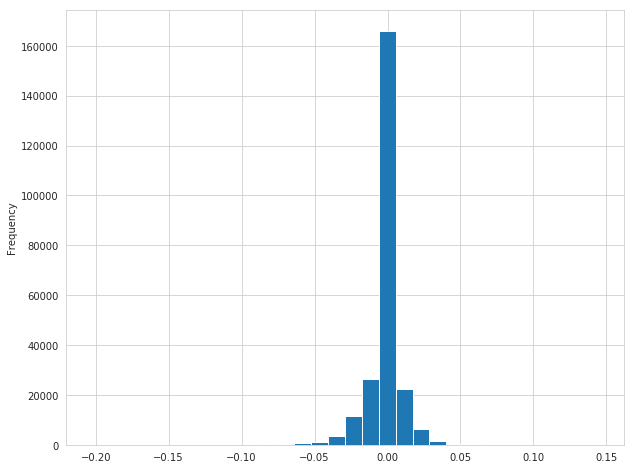

In [82]:
fig, ax = plt.subplots(figsize=(10,8))

texts_de['score'].plot.hist(bins=30)

plt.show()

In [83]:
most_neg = texts_de.sort_values(by=['score'])[0:10]
for i in most_neg.index:
    print(most_neg.loc[i]['text'])

Schwacher Windkraft-Ausbau gefährdet Kohleausstieg - https://t.co/1Neg78M4lY https://t.co/DAuJhcBaoq
Fehlerhaften Kohleausstieg vermeiden: https://t.co/pB5RGKJY0B
Steuerzahlerbund gegen Schulden https://t.co/x3wupX6vNI #hambibleibt
Plastikmüll ist tödliche Gefahr https://t.co/TKeeCK0ao4 #Radreise #hambibleibt
Plastikmüll ist tödliche Gefahr https://t.co/TKeeCK0ao4 #Radreise #hambibleibt
Das ist verdammt billig #HambiBleibt
das ist einfach unfair und gemein.
#hambibleibt https://t.co/RC9NQelIV4
Kohlekommission: Opposition unerwünscht https://t.co/kCzDmIN202
@dpa @RheinZeitung Schlechter Schachzug, ganz schlechter Schachzug. #hambibleibt
Kritik am Koalitionsvertrag: Klarer Kohleausstieg fehlt https://t.co/36EFmRMPPg


In [84]:
most_pos = texts_de.sort_values(by=['score'], ascending=False)[0:10]
for i in most_pos.index:
    print(most_pos.loc[i]['text'])

Wunderbar! #hambibleibt https://t.co/EFNyFZ0c0d
Aufatmen und riesige Freude! #hambibleibt https://t.co/rWCgwWAiYa
Große Freude! #Hambibleibt! https://t.co/flo1SlWGPl https://t.co/NVJeaAjpxn
#Kohleausstieg feiern bei bestem Wetter https://t.co/Qu8C9y4T5y
Ganz wunderbar diese Bechsteinfledermäuse #hambibleibt
Besonders wertvoll mit dem Zusatz #hambibleibt https://t.co/DrPOkrvjta
ja wunderbar #Kohleausstieg super Sache,sofort https://t.co/awhej2y8CA bitte_dringlichst_zu_handeln.#klimawandel https://t.co/CyiTbcDqr7
Freude für den #HambiBleibt https://t.co/zRGTrSiuFZ
Wunderbar. #hambibleibt #HambacherWald https://t.co/kOWL5T8RjP
Wunderbar dieses kreative Engagement miterleben zu dürfen. #Hambilebt #Hambibleibt #StopKohle https://t.co/V6SYutp7jF


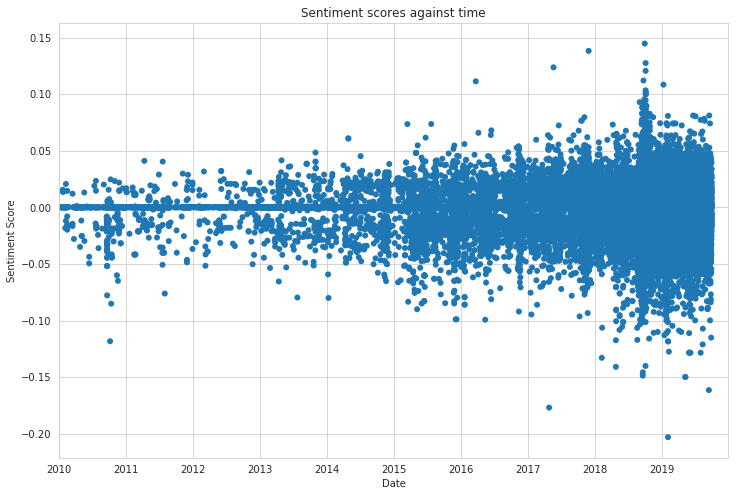

In [87]:
fig, ax = plt.subplots(figsize=(12,8))
sns.scatterplot(texts_de['created_at'], texts_de['score'], edgecolor='', ax = ax)
ax.set(xlim=(datetime.datetime.strptime('2010-01-01', '%Y-%m-%d'), datetime.datetime.strptime('2019-12-31', '%Y-%m-%d')), xlabel="Date",ylabel="Sentiment Score", title="Sentiment scores against time")
plt.show()

In [88]:
texts_de_daily = texts_de.groupby(pd.Grouper(key='created_at',freq='D'))['score'].mean()

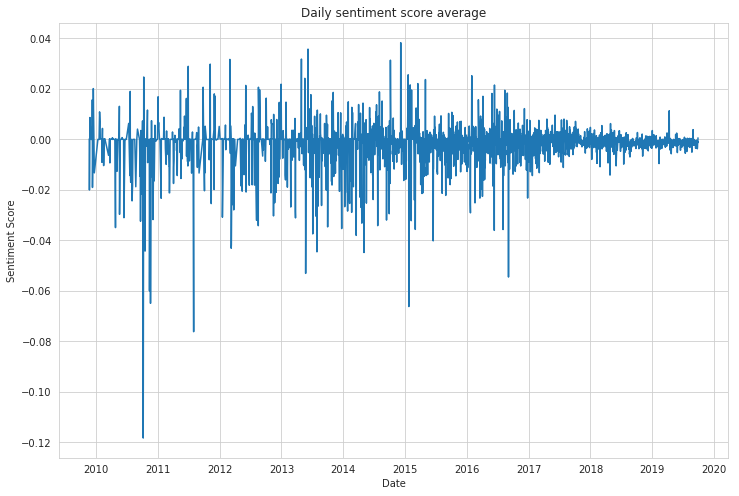

In [99]:
fig, ax = plt.subplots(figsize=(12,8))
sns.lineplot(texts_de_daily.index, texts_de_daily, ax = ax)
ax.set(xlabel="Date",
       ylabel="Sentiment Score", 
       title="Daily sentiment score average")
plt.show()
fig.savefig('plots/dailyavgsenti.png', dpi=300)

In [90]:
texts_de_monthly = texts_de.groupby(pd.Grouper(key='created_at',freq='M'))['score'].mean()

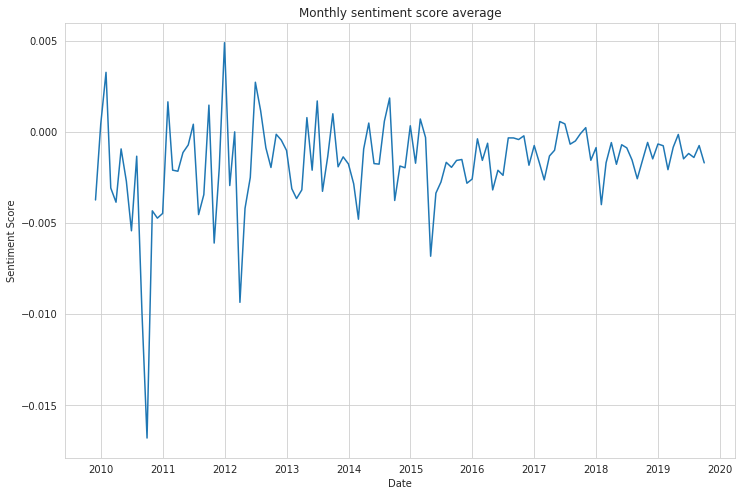

In [94]:
fig, ax = plt.subplots(figsize=(12,8))
sns.lineplot(texts_de_monthly.index, texts_de_monthly, ax = ax)
ax.set(xlabel="Date",ylabel="Sentiment Score", title="Monthly sentiment score average")
plt.show()
fig.savefig('plots/monthlyavgsenti.png', dpi=300)

In [95]:
texts_de_yearly = texts_de.groupby(pd.Grouper(key='created_at',freq='Y'))['score'].mean()

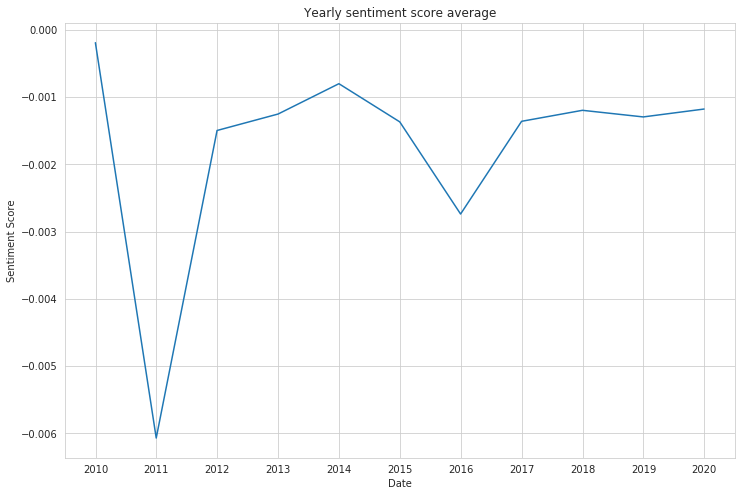

In [97]:
fig, ax = plt.subplots(figsize=(12,8))
sns.lineplot(texts_de_yearly.index, texts_de_yearly, ax = ax)
ax.set(xlabel="Date",ylabel="Sentiment Score", title="Yearly sentiment score average")
plt.show()
fig.savefig('plots/yearlyavgsenti.png', dpi=300)

### A Closer Look

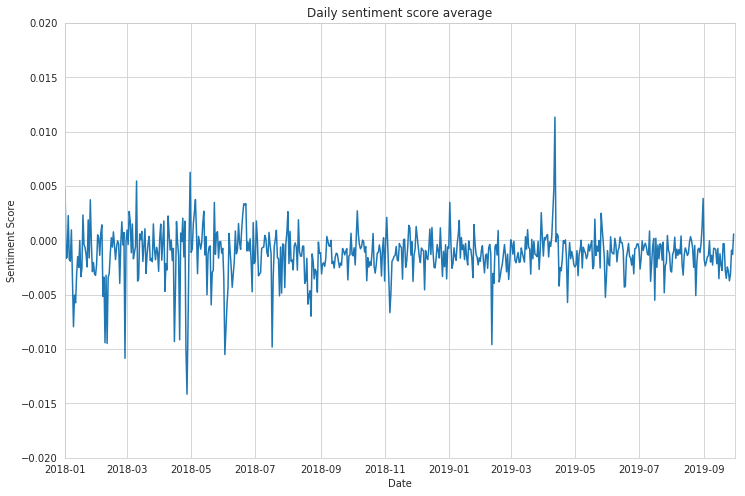

In [138]:
fig, ax = plt.subplots(figsize=(12,8))
sns.lineplot(texts_de_daily.index, texts_de_daily, ax = ax)
ax.set(xlim=(datetime.datetime.strptime('2018-01-01', '%Y-%m-%d'), datetime.datetime.strptime('2019-09-30', '%Y-%m-%d')),
       ylim=(-0.02,0.02),
       xlabel="Date",
       ylabel="Sentiment Score", 
       title="Daily sentiment score average")
plt.show()
#fig.savefig('plots/dailyavgsenti.png', dpi=300)

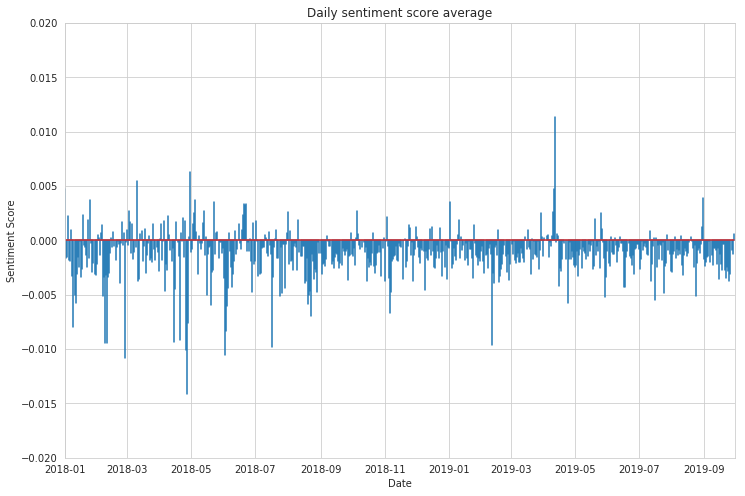

In [137]:
fig, ax = plt.subplots(figsize=(12,8))
#sns.lineplot(texts_de_daily.index, texts_de_daily, ax = ax)
ax.stem(texts_de_daily.index, texts_de_daily, markerfmt=' ')
ax.set(xlim=(datetime.datetime.strptime('2018-01-01', '%Y-%m-%d'), datetime.datetime.strptime('2019-09-30', '%Y-%m-%d')),
       ylim=(-0.02,0.02),
       xlabel="Date",
       ylabel="Sentiment Score", 
       title="Daily sentiment score average")
plt.show()
#fig.savefig('plots/dailyavgsenti.png', dpi=300)

In [130]:
start_date = datetime.datetime.strptime('2018-01-01-+0000', '%Y-%m-%d-%z')
end_date = datetime.datetime.strptime('2019-09-30-+0000', '%Y-%m-%d-%z')

In [131]:
date_range = (texts_de_daily.index >= start_date) & (texts_de_daily.index <= end_date)

In [133]:
texts_de_daily[date_range].sort_values(ascending=False)[:5]

created_at
2019-04-12 00:00:00+00:00    0.011332
2018-04-30 00:00:00+00:00    0.006256
2018-03-10 00:00:00+00:00    0.005457
2019-04-11 00:00:00+00:00    0.004763
2018-01-01 00:00:00+00:00    0.004754
Name: score, dtype: float64

In [135]:
texts_de_daily[date_range].sort_values()[:5]

created_at
2018-04-27 00:00:00+00:00   -0.014151
2018-02-27 00:00:00+00:00   -0.010848
2018-06-02 00:00:00+00:00   -0.010499
2018-04-26 00:00:00+00:00   -0.010057
2018-07-17 00:00:00+00:00   -0.009813
Name: score, dtype: float64

In [180]:
# return new column with date 
date_only = []
for i in texts_de.index:
    entry = texts_de.loc[i]
    entry_date = entry['created_at'].date()
    date_only.append(entry_date)

In [181]:
texts_de['date_only'] = date_only
texts_de.head()

/home/leey/tmv/BasicBrowser/venv/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


,id,created_at,text,lang,score,date_only
1,5944270614,2009-11-22 11:55:21+00:00,"Die USA bremsen #Klimaabkommen, weil sie noch ...",de,0.000174,2009-11-22
2,5978704331,2009-11-23 15:17:24+00:00,#Schottland: #Waldbesetzung gegen #Kohle-#Tage...,de,-0.020047,2009-11-23
3,6089959841,2009-11-26 19:18:40+00:00,#Klimaschutz: Eine Maßnahme hilft wirklich: Ko...,de,0.008653,2009-11-26
4,6230764335,2009-12-01 09:41:27+00:00,ak2 diskutiert Mindestwirkungsgrad bei Kohle- ...,de,0.000000,2009-12-01
5,6265364638,2009-12-02 10:05:53+00:00,#Klimawandel: im Moment haben offenbar die Pro...,de,0.000000,2009-12-02


In [189]:
positive_day = texts_de['date_only'] == datetime.date(2019,4,12)
positive_day_tweets = texts_de[positive_day]

In [205]:
positive_day_tweets.sort_values(by='score', ascending=False)[:20]

,id,created_at,text,lang,score,date_only
223251,1116672151451504641,2019-04-12 11:59:22+00:00,Gelungene Premiere in Fürth - Danke @FridaysFo...,de,0.052632,2019-04-12
223246,1116668024415838208,2019-04-12 11:42:58+00:00,Großartig - Danke @FfFbbg_ \n#FridaysForFurtur...,de,0.027094,2019-04-12
223254,1116675868053712896,2019-04-12 12:14:08+00:00,@Luisamneubauer Ich möchte nicht auf meinen St...,de,0.026354,2019-04-12
223025,1116516717281198081,2019-04-12 01:41:43+00:00,RT @Luisamneubauer: Was die Regierung damit sa...,de,0.025593,2019-04-12
223168,1116628677918371840,2019-04-12 09:06:37+00:00,RT @Luisamneubauer: Was die Regierung damit sa...,de,0.025593,2019-04-12
223170,1116629081150361600,2019-04-12 09:08:13+00:00,RT @Luisamneubauer: Was die Regierung damit sa...,de,0.025593,2019-04-12
223174,1116630177075744768,2019-04-12 09:12:34+00:00,RT @Luisamneubauer: Was die Regierung damit sa...,de,0.025593,2019-04-12
223175,1116631331738464256,2019-04-12 09:17:10+00:00,RT @Luisamneubauer: Was die Regierung damit sa...,de,0.025593,2019-04-12
223178,1116632776827129856,2019-04-12 09:22:54+00:00,RT @Luisamneubauer: Was die Regierung damit sa...,de,0.025593,2019-04-12
223180,1116633446267392005,2019-04-12 09:25:34+00:00,RT @Luisamneubauer: Was die Regierung damit sa...,de,0.025593,2019-04-12


In [204]:
most_pos_day = positive_day_tweets.sort_values(by='score', ascending=False)
for i in most_pos_day.index[:10]:
    print(most_pos_day.loc[i]['text'])

Gelungene Premiere in Fürth - Danke @FridaysForFut12 
#FridaysForFurture #ParentsForFuture #ScientistsForFuture #alledörferbleiben #hambibleibt https://t.co/PcC7htJMSF
Großartig - Danke @FfFbbg_ 
#FridaysForFurture #ParentsForFuture #scientists4future #alledörferbleiben #hambibleibt https://t.co/1mYUu7RoYI
@Luisamneubauer Ich möchte nicht auf meinen Strom verzichten. Alle, die aber keinen Strom haben möchten, dürfen gerne für einen früheren Kohleausstieg demonstrieren...
RT @Luisamneubauer: Was die Regierung damit sagen möchte: Da hat die Kohlekommission ein Datum auf den Tisch gelegt, was uns so gut in den…
RT @Luisamneubauer: Was die Regierung damit sagen möchte: Da hat die Kohlekommission ein Datum auf den Tisch gelegt, was uns so gut in den…
RT @Luisamneubauer: Was die Regierung damit sagen möchte: Da hat die Kohlekommission ein Datum auf den Tisch gelegt, was uns so gut in den…
RT @Luisamneubauer: Was die Regierung damit sagen möchte: Da hat die Kohlekommission ein Datum auf den T

#### @Luisamneubauer
> Was die Regierung damit sagen möchte: Da hat die Kohlekommission ein Datum auf den Tisch gelegt, was uns so gut in den Kram passt - wäre ja schön blöd nur wegen so ein paar Halbstarken auf einmal echten Klimaschutz durchzusetzen, der wohlmöglich noch dem Parisabkommen entspricht.

In [206]:
negative_day = texts_de['date_only'] == datetime.date(2018,4,27)
negative_day_tweets = texts_de[negative_day]

In [208]:
negative_day_tweets.sort_values(by='score')[:20]

,id,created_at,text,lang,score,date_only
53433,989814016808759297,2018-04-27 10:30:26+00:00,Kohlekommission: Opposition unerwünscht #endco...,de,-0.100629,2018-04-27
53425,989792125171597312,2018-04-27 09:03:26+00:00,RWE sieht bei Kohleausstieg Eigentumsrechte in...,de,-0.090909,2018-04-27
53456,989891967596167169,2018-04-27 15:40:11+00:00,#FFD365 #Aktuell - Kohlekommission: Opposition...,de,-0.070440,2018-04-27
53418,989760865162248192,2018-04-27 06:59:13+00:00,#FFD365 #Aktuell - Kohlekommission: Opposition...,de,-0.070440,2018-04-27
53461,989947332723662850,2018-04-27 19:20:11+00:00,#FFD365 #Aktuell - Kohlekommission: Opposition...,de,-0.070440,2018-04-27
53420,989778470568853504,2018-04-27 08:09:11+00:00,#FFD365 #Aktuell - Kohlekommission: Opposition...,de,-0.070440,2018-04-27
53440,989834374723063808,2018-04-27 11:51:19+00:00,#Kohlekommission: Opposition unerwünscht | Tel...,de,-0.058700,2018-04-27
53446,989843487980912641,2018-04-27 12:27:32+00:00,Kampf um die #Kohle - und #endegelaende mitten...,de,-0.031600,2018-04-27
53429,989806005801377797,2018-04-27 09:58:36+00:00,Kohlekonzern RWE sieht bei #Kohleausstieg Eige...,de,-0.022881,2018-04-27
53451,989859715969667075,2018-04-27 13:32:01+00:00,"Finnland kündigt #Kohleausstieg für 2029 an, z...",de,-0.022511,2018-04-27


In [212]:
most_neg_day = negative_day_tweets.sort_values(by='score')
for i in most_neg_day.index[:10]:
    print(most_neg_day.loc[i]['text'])

Kohlekommission: Opposition unerwünscht #endcoal https://t.co/7cylpClwCj
RWE sieht bei Kohleausstieg Eigentumsrechte in Gefahr / 27.04.2018 https://t.co/YhvGiobGuV https://t.co/y5QaYPvCRf
#FFD365 #Aktuell - Kohlekommission: Opposition unerwünscht https://t.co/XHCX3FoYXQ
#FFD365 #Aktuell - Kohlekommission: Opposition unerwünscht https://t.co/XHCX3FoYXQ
#FFD365 #Aktuell - Kohlekommission: Opposition unerwünscht https://t.co/XHCX3F7o6i
#FFD365 #Aktuell - Kohlekommission: Opposition unerwünscht https://t.co/XHCX3F7o6i
#Kohlekommission: Opposition unerwünscht | Telepolis https://t.co/QtKosu2X1S #endcoal #kohleabschalten
Kampf um die #Kohle - und #endegelaende mittendrin ✊ #Kohleausstieg ist Handarbeit! https://t.co/7orzxd10Sv
Kohlekonzern RWE sieht bei #Kohleausstieg Eigentumsrechte in Gefahr  (Sonst ist denen "Eigentum" anderer auch nicht so wichtig) #endcoal  https://t.co/z4LQ3HrI5x
Finnland kündigt #Kohleausstieg für 2029 an, zudem Subventionen für diejenigen, die sogar vorzeitig vom Net

---

## Looking at specific events

### Launch of coal commission 2018-06-06

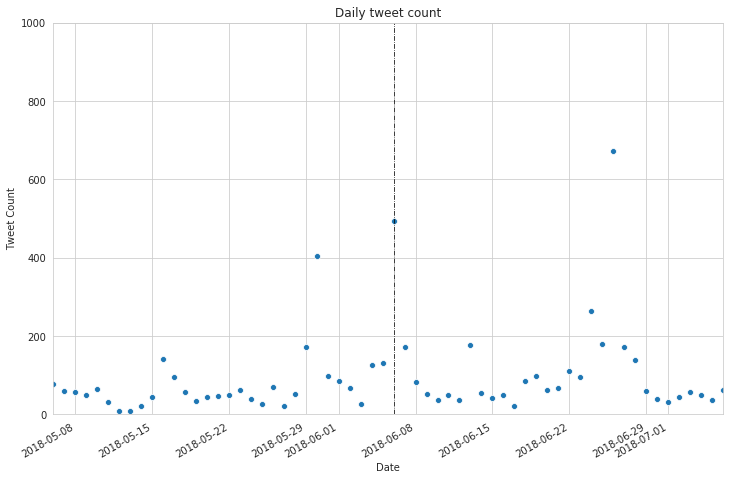

In [252]:
# tweet freq
fig, ax = plt.subplots(figsize=(12,8))
sns.scatterplot(texts_de_daily_count.index, texts_de_daily_count)
ax.set(xlim=(datetime.datetime.strptime('2018-05-06', '%Y-%m-%d'), datetime.datetime.strptime('2018-07-06', '%Y-%m-%d')),
       ylim=(0,1000),
       xlabel="Date",
       ylabel="Tweet Count", 
       title="Daily tweet count")
ax.axvline(x=(datetime.datetime.strptime('2018-06-06', '%Y-%m-%d')), ls ='-.',lw='0.75', c = 'k')
fig.autofmt_xdate()
plt.show()

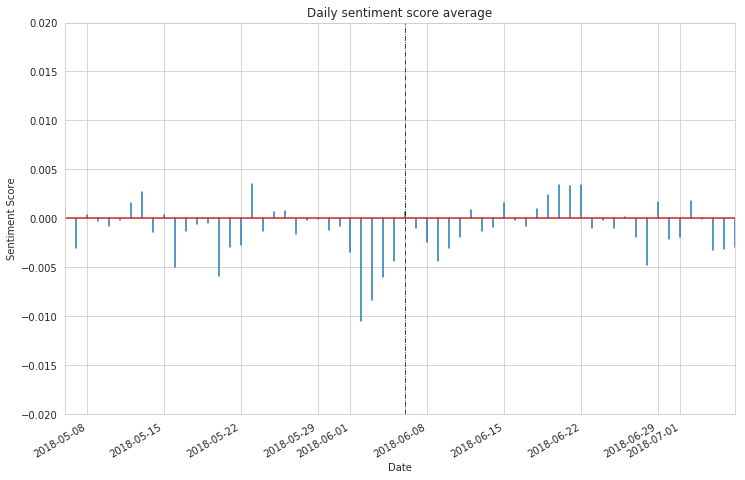

In [273]:
# sentiment scores
fig, ax = plt.subplots(figsize=(12,8))
#sns.lineplot(texts_de_daily.index, texts_de_daily, ax = ax)
ax.stem(texts_de_daily.index, texts_de_daily, markerfmt=' ')
ax.set(xlim=(datetime.datetime.strptime('2018-05-06', '%Y-%m-%d'), datetime.datetime.strptime('2018-07-06', '%Y-%m-%d')),
       ylim=(-0.02,0.02),
       xlabel="Date",
       ylabel="Sentiment Score", 
       title="Daily sentiment score average")
#ax.axvline(x=(datetime.datetime.strptime('2018-06-06', '%Y-%m-%d')), ls ='-.',lw='0.75', c = 'k')
fig.autofmt_xdate()
plt.show()

In [237]:
# tweets 
event1 = texts_de['date_only'] == datetime.date(2018,6,6)
event1_tweets = texts_de[event1]

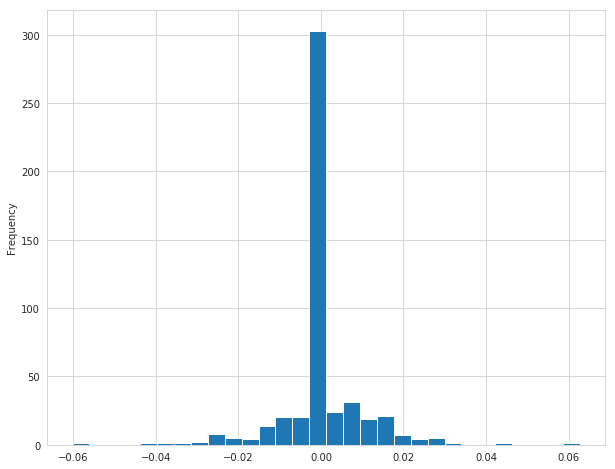

In [244]:
# spread of scores in the day
fig, ax = plt.subplots(figsize=(10,8))

event1_tweets['score'].plot.hist(bins=30)

plt.show()

In [239]:
event1_pos = event1_tweets.sort_values(by='score', ascending=False)
for i in event1_pos.index[:10]:
    print(event1_pos.loc[i]['text'])

Kohlekommission sollte mit Ruhe und Sorgfalt agieren https://t.co/3369hC4Bt3
📋 Kohlekommission sollte mit Ruhe und Sorgfalt agieren https://t.co/cgt6iejaFq ❚DIHK
Heute wird die #Kohlekomission vom Bundeskabinett berufen. Mut zur Lücke braucht sie sicherlich nicht 😉 Denn bei aktuellem Trend würde die Lücke zu unseren #Klimaschutz-Zielen von alleine immer größer.  Mut zum #Kohleausstieg! https://t.co/L7dTcmPjCI
Heute startet die #Kohlekommission. @martinkaisergp beantwortet die wichtigsten Fragen https://t.co/E8ua25PR2g https://t.co/KAMNhx2EBB
Grünen-Chefin @ABaerbock ist sauer über Ausschluss der Oppositionsfraktionen aus der #Kohlekommission - hofft aber trotzdem auf deren Erfolg: https://t.co/rDpvP7Dxs0
Hübsche Tante und ihr großer Arsch wurden schön gefickt.

https://t.co/x88LBeWkyQ

#JurassicWorldFallenKingdom #Horizons #Regierungsbefragung #HSK18 #Kohlekommission #astro_alex Parlement 
Bundestag Kanzlerin Alexander Gerst
RT @campact: #GroKo beschließt #Kohlekommission, Wir fordern:

In [240]:
event1_neg = event1_tweets.sort_values(by='score')
for i in event1_neg.index[:10]:
    print(event1_neg.loc[i]['text'])

Schellnhuber: Zögerlicher Kohleausstieg würde bestraft https://t.co/nfCq3ovmnI https://t.co/lmte7nMRVL
.@lgbeutin : #Kohlekommission ist undemokratischer Groko-Debattierclub https://t.co/H3FKj2PRRJ
Kohlekommission darf keine Zeit mehr verlieren! https://t.co/j6w2WfxUzS via @ChangeGER
Wie Kohleausstieg @DFoest ? Atomkraft ist fast weg. Was sollen wir nachts bei schwachem Wind tun? Oder von Oktober bis Februar 16-10 Uhr? https://t.co/8rPQRD3VTD
zur #Petition Kohlekommission darf keine Zeit mehr verlieren! https://t.co/6EGPz5LUPu via @ChangeGER
(KR) Kohleausstieg - oder Kommissionsausstieg:

Gelingt es der Kommission, einen Kohlekonsens zu schmieden, der nicht zu Lasten der Klimaziele geht, müsste alle andere Kritik zurückstehen. Doch die Chancen darauf sind eher gering.

https://t.co/KoQJfv29wr
Die Einsetzung einer #Kohlekommission in der keines der Worte #Kohleausstieg, #Klimaschutz oder #Energiewende im Titel vorkommen - finde den Fehler!
Die Weltraumschnecke steht für schlechte Wortwi

### Launch of report 2019-01-26

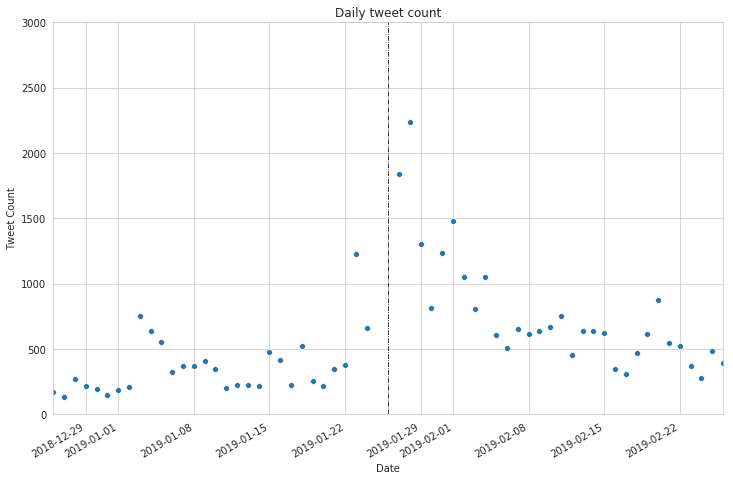

In [274]:
# tweet freq
fig, ax = plt.subplots(figsize=(12,8))
sns.scatterplot(texts_de_daily_count.index, texts_de_daily_count)
ax.set(xlim=(datetime.datetime.strptime('2018-12-26', '%Y-%m-%d'), datetime.datetime.strptime('2019-02-26', '%Y-%m-%d')),
       ylim=(0,3000),
       xlabel="Date",
       ylabel="Tweet Count", 
       title="Daily tweet count")
ax.axvline(x=(datetime.datetime.strptime('2019-01-26', '%Y-%m-%d')), ls ='-.',lw='0.75', c = 'k')
fig.autofmt_xdate()
plt.show()

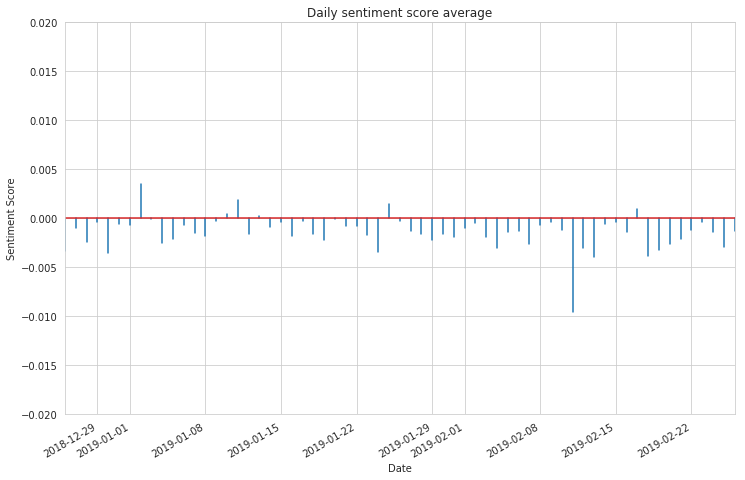

In [228]:
# sentiment scores
fig, ax = plt.subplots(figsize=(12,8))
#sns.lineplot(texts_de_daily.index, texts_de_daily, ax = ax)
ax.stem(texts_de_daily.index, texts_de_daily, markerfmt=' ')
ax.set(xlim=(datetime.datetime.strptime('2018-12-26', '%Y-%m-%d'), datetime.datetime.strptime('2019-02-26', '%Y-%m-%d')),
       ylim=(-0.02,0.02),
       xlabel="Date",
       ylabel="Sentiment Score", 
       title="Daily sentiment score average")
fig.autofmt_xdate()
plt.show()

In [245]:
# tweets 
event2 = texts_de['date_only'] == datetime.date(2019,1,26)
event2_tweets = texts_de[event2]

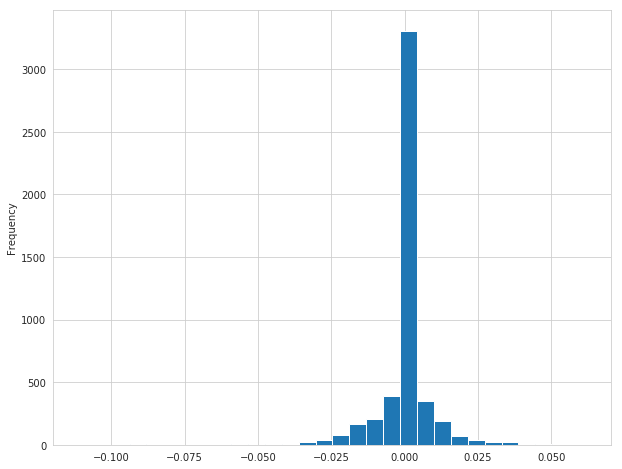

In [246]:
# spread of scores in the day
fig, ax = plt.subplots(figsize=(10,8))

event2_tweets['score'].plot.hist(bins=30)

plt.show()

In [247]:
event2_pos = event2_tweets.sort_values(by='score', ascending=False)
for i in event2_pos.index[:10]:
    print(event2_pos.loc[i]['text'])

Kohlekommission auch nur gut bezahlter Handballfamclub
Kohleausstieg: Zwischen Schacht und großer Chance
#Kohleausstieg bis 2038. Ja super - sehr, sehr ehrgeizig. https://t.co/3OMW5Az5fa
@DanielHofing Ist doch ein super Erfolg!!! Für RWE zum Beispiel...😡 #hambibleibt
@MarjaKatz Gute Frage!! Für NICHTS!! Beste Lobbyarbeit in der Kohlekommission.
#Kohleausstieg bei gleichzeitigem #Atomausstieg wird energiewirtschaftlich nicht funktionieren. Das wird spannend.
Was wollen die Leute? Einen möglichst schnellen #Kohleausstieg finden 73 Prozent sehr wichtig oder wichtig, 18 Prozent weniger wichtig und nur 7 Prozent überhaupt nicht wichtig via @ZDF https://t.co/FEOxETknMd #Kohlekommission https://t.co/OEpmtarYFG
Kohleausstieg: Zwischen Minimalkompromiss und großer Chance https://t.co/Jq7YScswPU
Kohleausstieg: Zwischen Minimalkompromiss und großer Chance https://t.co/eBK5gVcV9E https://t.co/810OfhTWw4
Kohleausstieg: Zwischen Minimalkompromiss und großer Chance https://t.co/O7dJTr1br3 https://t.c

In [248]:
event2_neg = event2_tweets.sort_values(by='score')
for i in event2_neg.index[:10]:
    print(event2_neg.loc[i]['text'])

Kohleausstieg: Altmaier sieht Stromversorgung nicht in Gefahr https://t.co/zwaLxygYpp
Kohleausstieg: Altmaier sieht Stromversorgung nicht in Gefahr - https://t.co/N44Gnixr88
#Kohlekommission: Es drohen unnötig harte Eingriffe. Wirtschaft, Gewerkschaften und Regionen haben hart gekämpft. DEBRIV-Presseinfo 2/2019 https://t.co/nnvxV23tKz
UN-Sicherheitsrat: Maas warnt vor Gefahren des Klimawandels https://t.co/pAmLbnC8nG #hambibleibt
Kohleausstieg: Altmaier sieht Stromversorgung nicht in Gefahr - https://t.co/eCJyXydQWb https://t.co/uHCvNBnYwz
Kohleausstieg: Altmaier sieht Stromversorgung nicht in Gefahr https://t.co/pIYw1OvNoM https://t.co/BKvJE3t34A
Kohleausstieg: Altmaier sieht Stromversorgung nicht in Gefahr https://t.co/du720M9Oyx https://t.co/Uf0WqlT1q3
Kohleausstieg: Altmaier sieht Stromversorgung nicht in Gefahr
 #nachrichten
 https://t.co/HoPrQpxM4A
Belogen, betrogen zum hassen erzogen!https://t.co/AKdTyCkF3P #hambibleibt
🔴 Kohleausstieg 🔴❓ Steigen die Strompreise ❓ BESTIMMT ❓ ARB

### Hambach Forest debate 2018-10-05
> "Court rules clearing operations at Hambach Forest have to be stopped" - CEW

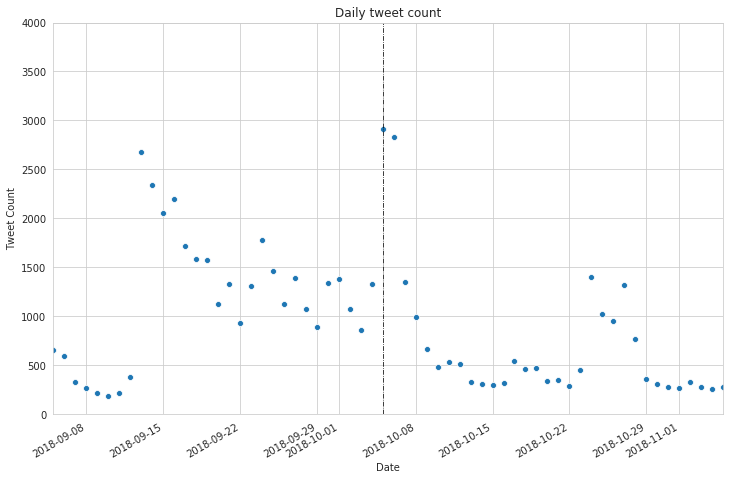

In [275]:
# tweet freq
fig, ax = plt.subplots(figsize=(12,8))
sns.scatterplot(texts_de_daily_count.index, texts_de_daily_count)
ax.set(xlim=(datetime.datetime.strptime('2018-09-05', '%Y-%m-%d'), datetime.datetime.strptime('2018-11-05', '%Y-%m-%d')),
       ylim=(0,4000),
       xlabel="Date",
       ylabel="Tweet Count", 
       title="Daily tweet count")
ax.axvline(x=(datetime.datetime.strptime('2018-10-05', '%Y-%m-%d')), ls ='-.',lw='0.75', c = 'k')
fig.autofmt_xdate()
plt.show()

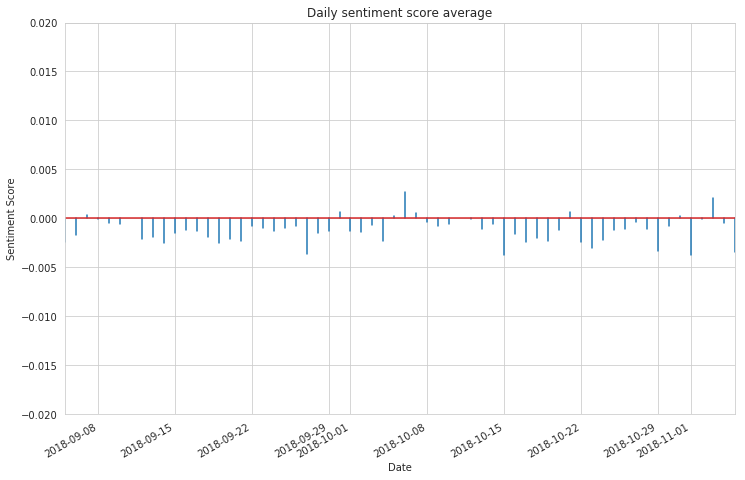

In [232]:
# sentiment scores
fig, ax = plt.subplots(figsize=(12,8))
#sns.lineplot(texts_de_daily.index, texts_de_daily, ax = ax)
ax.stem(texts_de_daily.index, texts_de_daily, markerfmt=' ')
ax.set(xlim=(datetime.datetime.strptime('2018-09-05', '%Y-%m-%d'), datetime.datetime.strptime('2018-11-05', '%Y-%m-%d')),
       ylim=(-0.02,0.02),
       xlabel="Date",
       ylabel="Sentiment Score", 
       title="Daily sentiment score average")
fig.autofmt_xdate()
plt.show()

In [249]:
# tweets 
event3 = texts_de['date_only'] == datetime.date(2018,10,5)
event3_tweets = texts_de[event3]

In [250]:
event3_pos = event3_tweets.sort_values(by='score', ascending=False)
for i in event3_pos.index[:10]:
    print(event3_pos.loc[i]['text'])

Große Freude! #Hambibleibt! https://t.co/flo1SlWGPl https://t.co/NVJeaAjpxn
Ganz wunderbar diese Bechsteinfledermäuse #hambibleibt
Wunderbar. #hambibleibt #HambacherWald https://t.co/kOWL5T8RjP
Auch super #Hambibleibt https://t.co/0At4KdZ7Rv
Toller Erfolg! #hambibleibt #lorien  https://t.co/fwc6ZX0JOk
Tolle Neuigkeiten! #hambibleibt https://t.co/cysxrRVBuP
@Das_Otz Und nächstes Jahr blühen dort wieder wunderschöne gelbe Blumen 💐 
#hambibleibt
Sehr tolle Nachrichten! #hambibleibt https://t.co/U2NqL5H0s2
Spannender Beitrag von @TeamKenFM zur Thematik. #Hambibleibt https://t.co/QWmIQMTqoA
So wird der Samstag der perfekten Demotag. #hambibleibt https://t.co/DQMZrwoP0U


In [251]:
event3_neg = event3_tweets.sort_values(by='score')
for i in event3_neg.index[:10]:
    print(event3_neg.loc[i]['text'])

Schlechter Verlierer,
#Wette gewonnen 👍 #Hambibleibt https://t.co/nRGdQNxMcF
Verbietet ihr die Demo, verbieten wir das Roden hahahahahaha #hambibleibt für immer
Aber #hambibleibt Demo verbieten. 😠 https://t.co/1l6p9ZUjXY
Polizei verbietet geplante Großdemonstration https://t.co/OfJiRSl6Ot via @zeitonline #Hambibleibt
"Es droht eine Kettenreaktion von Verlusten" https://t.co/mzvmsJDCha #HambacherForst #hambibleibt
der ist eh verloren #hambibleibt
#HambacherForst #Hambibleibt https://t.co/o19nOByfCm Polizei verbietet Großdemonstration - https://t.co/ghSXqpiqZR
Polizei Aachen verbietet Großdemo am Hambacher Forst https://t.co/Yim19xtnKp #HambiBleibt
#HambacherForst #Hambibleibt https://t.co/5qvu5aWwf8 Polizei verbietet Großdemonstration - https://t.co/ghSXqpiqZR
Ein Wald soll für immer vernichtet werden für veralteten, dreckigen Strom und Profit und die Polizei argumentiert bei Aktionen gegen diesen Unsinn mit "Brandgefahr" und "erhebliche Gefahr für die öffentliche Sicherheit".

#HambiBl